# Analyse SHAP values

In [10]:
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_preprocess import pipe_imputation_scaling, pipe_supervisedSelector
import shap
import pickle

from sklearn.pipeline import Pipeline

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, brier_score_loss, roc_auc_score, average_precision_score, f1_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from statkit import decision

In [2]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
datasetTimepoint = "PRESURGERY"
target = "Conclusion_micro"
target_rkz = "GAS_yes_no"
percentBoruta = 100
n_iter = 10000


''' 
Define paths
'''
folderFigures = f"{PATH}/figures/{datasetTimepoint}/50_externalValidation"
resultsPath = f"{PATH}/results/50_externalValidation/{datasetTimepoint}/"
dataPath = f"{PATH}/results/10_preprocessed/validation"

''' 
Read validation data
'''
with open(f"{PATH}/data/validation/validation_dtypes.json", "r") as f:
    dtypes = json.load(f)

data = pd.read_csv(f"{dataPath}/{datasetTimepoint}_{target}_validationData.csv", index_col=None, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())


''' 
Split
'''
X_val = data.drop(target_rkz, axis=1)
y_val = data[target_rkz]#.values

In [3]:
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_validation_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

In [11]:
dic_performanceScores = {
    "acc":np.array([]),
    "prec":np.array([]),
    "recall":np.array([]),
    "f1-score":np.array([]),
    "brier":np.array([]),
    "roc_auc":np.array([]),
    "pr":np.array([]),
}
for run in range(data.shape[1]):
    predproba = data[run][data[run].notna()]
    pred = predproba.copy()
    pred[predproba < 0.5] = 0
    pred[predproba >= 0.5] = 1
    tru = y_val.loc[predproba.index]   
    
    ## Accuracy
    dic_performanceScores["acc"] = np.append(dic_performanceScores["acc"],balanced_accuracy_score(tru, pred))
    ## Precision
    dic_performanceScores["prec"] = np.append(dic_performanceScores["prec"],precision_score(tru, pred))
    ## Recall
    dic_performanceScores["recall"] = np.append(dic_performanceScores["recall"],recall_score(tru, pred))
    # F1-score
    dic_performanceScores["f1-score"] = np.append(dic_performanceScores["f1-score"],f1_score(tru, pred))
    ## Brier
    dic_performanceScores["brier"] = np.append(dic_performanceScores["brier"],brier_score_loss(tru, predproba))
    ## ROC AUC
    dic_performanceScores["roc_auc"] = np.append(dic_performanceScores["roc_auc"],roc_auc_score(tru, predproba))
    ## PR
    dic_performanceScores["pr"] = np.append(dic_performanceScores["pr"],average_precision_score(tru, predproba))

df_scores = pd.DataFrame.from_dict(dic_performanceScores)

df_scores

,acc,prec,recall,f1-score,brier,roc_auc,pr
0,0.675926,0.666667,0.500000,0.571429,0.196133,0.721965,0.654645
1,0.675000,0.687500,0.488889,0.571429,0.195762,0.749074,0.685256
2,0.691426,0.729730,0.509434,0.600000,0.204896,0.719011,0.678103
3,0.695998,0.812500,0.464286,0.590909,0.202603,0.740426,0.706357
4,0.683346,0.750000,0.470588,0.578313,0.200932,0.725745,0.697954
...,...,...,...,...,...,...,...
9995,0.688171,0.764706,0.472727,0.584270,0.199337,0.745235,0.670340
9996,0.624813,0.606061,0.408163,0.487805,0.218025,0.679318,0.612290
9997,0.718272,0.736842,0.560000,0.636364,0.178806,0.780988,0.718060
9998,0.668372,0.702703,0.481481,0.571429,0.207194,0.730629,0.695476


# Calculate CI

In [12]:
""" 
Calculate confidence intervals 
"""
df_ci = pd.DataFrame()
for col in df_scores.columns:
    df_ci[col] = np.array([np.mean(df_scores[col]),np.percentile(df_scores[col], 2.5), np.percentile(df_scores[col], 97.5)])
df_ci.index = ["mean", "lower_CI", "upper_CI"]

#### Save to file
df_ci.to_csv(f"{resultsPath}/bootstrap_CI_95%.csv")

In [13]:
for i, col in enumerate(df_ci.columns):
    print(col)
    print("%.3f" % df_ci.iloc[0, i], "(%.3f," % df_ci.iloc[1, i], "%.3f)" % df_ci.iloc[2, i])
    print("\n")

acc
0.670 (0.624, 0.718)


prec
0.697 (0.615, 0.788)


recall
0.476 (0.396, 0.560)


f1-score
0.565 (0.488, 0.637)


brier
0.205 (0.181, 0.228)


roc_auc
0.727 (0.672, 0.783)


pr
0.666 (0.594, 0.736)




# Net benefit

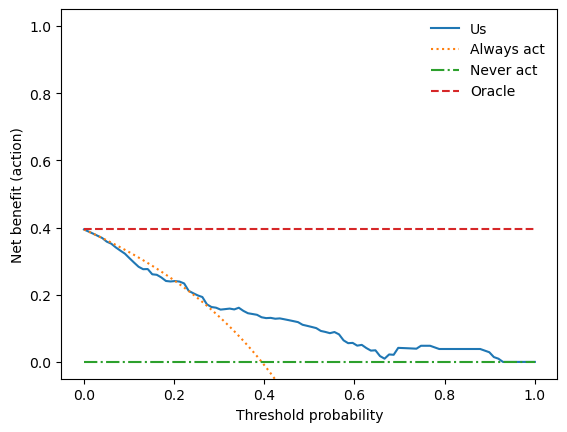

In [7]:
b = data.T.mean().sort_index()
c = y_val.loc[b.index]

fig, ax = plt.subplots()
decision.NetBenefitDisplay.from_predictions(c, b, name='Us', ax=ax)
#ax.set_ylim(0-.1,.33)